# Doing statistics using python

This notebook aims to present how to perform classical statiscial procedure as well as some amount of regression using various python libraries, such as `scipy`.

It **does not aim to replace a course on statistics**, but rather focuses on the code aspect.

In [3]:
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats 
import pandas as pd
import numpy as np

# Toc <a id='toc'></a>

<br>

 1. [SciPy.stats and statistics in python](#stats)

    1.1 [manipulation of random distributions](#stats.1)

    1.1.1 [Drawing some random numbers : rvs](#stats.1.1)

    1.1.2 [Looking up the quantiles and probability density functions](#stats.1.2)

    1.2 [t-test](#stats.2)

    1.3 [statistical power calculations](#stats.3)

    1.4 [Multiple hypothesis testing](#stats.4)

    1.5 [Fisher's exact test and the Chi-square test](#stats.5)

    1.6 [1-way anova](#stats.6)
<br>

 2. [Correlation and linear regression](#reg)

    2.1 [Correlation](#reg.1)

    2.2 [Regression](#reg.2)
<br>

[back to toc](#toc)

[back to toc](#toc)

<br>

# 1. SciPy.stats and statistics in python <a id='stats'></a>


SciPy references a comprehensive [project for scientific python programming](https://scipy.org) regrouping as well  as a [library](https://docs.scipy.org/doc/scipy/reference/) (which is part of the project) implementing various tools and algorithm for scientific software.

Here we will give a few pointers on the `scipy.stats` library, which provides ways to interact with various random distribution functions, as well as implement numerous statistical tests.


[back to toc](#toc)

## 1.1 manipulation of random distributions <a id='stats.1'></a>

scipy.stats implements utilisties for a large number of continuous and discrete distributions :

In [4]:
from scipy import stats

dist_continu = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
dist_discrete = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_discrete)]
print('number of continuous distributions: %d' % len(dist_continu))
print('number of discrete distributions:   %d' % len(dist_discrete))


number of continuous distributions: 101
number of discrete distributions:   16


let's experiment with the normal distribution, or `norm` in `scipy.stats`


A look at `help(stats.norm)` tells us that 
```
 |  The location (``loc``) keyword specifies the mean.
 |  The scale (``scale``) keyword specifies the standard deviation.
```


In [5]:
## we can generate a specific normal distribution :
N = stats.norm(loc = 10 , scale = 2)

# the mean and variance of a distribution can be retrieved using the .stats method :
print(N.stats())

(array(10.), array(4.))


That object can then be used to interact with the distribution in many ways.


### 1.1.1. Drawing some random numbers : rvs <a id='stats.1.1'></a>

In [6]:
# draw some random number in this distribution : rvs
# the size argument is 1 or several integers and defines the dimensions of the returned arrays of random numbers
N.rvs(size = [50]) 

array([10.75511851,  9.60780348, 12.93968898, 11.17495391, 12.44426182,
        8.53360209,  7.62174386,  9.74826542,  9.49424035, 15.44824695,
       10.33618503, 11.57064744, 10.02240922, 13.6674403 ,  9.84085785,
        8.85815175, 11.52026055, 10.23342923, 11.17626184, 12.48838033,
       11.69696291, 10.64979644, 17.40943756, 12.29372458, 13.81131453,
        8.10733842, 11.79250717, 12.54794442, 11.90208412, 13.12948181,
        8.27961401,  9.51789573, 11.39537307,  9.59465422,  9.63794631,
       12.65370096,  7.49204662, 10.12176074, 10.82096877,  9.5684866 ,
       10.9921896 ,  7.95271278,  9.0812498 , 11.51458621,  9.37322595,
       13.46111999, 12.67627654, 11.25017588, 13.84296633, 10.56988034])

(array([1.000e+00, 1.000e+01, 6.500e+01, 3.600e+02, 9.960e+02, 1.575e+03,
        1.267e+03, 5.810e+02, 1.290e+02, 1.600e+01]),
 array([ 0.79275904,  2.42350084,  4.05424264,  5.68498444,  7.31572624,
         8.94646804, 10.57720984, 12.20795164, 13.83869344, 15.46943525,
        17.10017705]),
 <BarContainer object of 10 artists>)

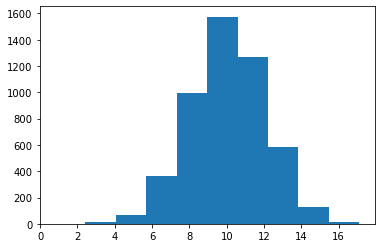

In [7]:
plt.hist( N.rvs(size = [5000])  ) 

as with any drawing of random variable on a computer, [one merely emulates randomness](https://en.wikipedia.org/wiki/Pseudorandom_number_generator). This also means that one can make some random operation reproducible by setting up the random seed.



In [8]:
import numpy as np
np.random.seed(2021) # we set the random seed
draw1 = N.rvs(size=5)
np.random.seed(2021) # we set the random seed back to 2021
draw2 = N.rvs(size=5)
print("Are the ramdom draws equal?",draw1 == draw2)
print(draw1)
print(draw2)

Are the ramdom draws equal? [ True  True  True  True  True]
[12.97721811 11.35202174  9.16309726  8.38695837 11.11175166]
[12.97721811 11.35202174  9.16309726  8.38695837 11.11175166]


### 1.1.2 Looking up the quantiles and probability density functions <a id='stats.1.2'></a>


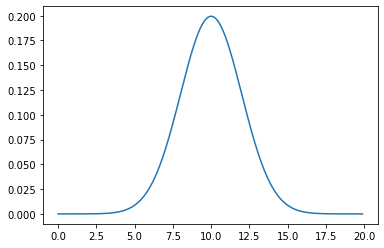

what is the probability of drawing a number <=15.0 ? 0.9937903346742238
quantiles: [0.025, 0.5, 0.975] -> [ 6.08007203 10.         13.91992797]


In [9]:
#  pdf: Probability Density Function
# I know this is not the plotting lesson, but here is a small recipe to plot the distribution
import matplotlib.pyplot as plt 
X = np.arange(0,20,0.1)
plt.plot( X , N.pdf(X) )
plt.show()

#    cdf: Cumulative Distribution Function
print('what is the probability of drawing a number <=15.0 ?' ,  N.cdf(15.0)) 


#    ppf: Percent Point Function (Inverse of CDF) , gives the quantiles of the distribution
P = [0.025,0.5,0.975]
Q = N.ppf(P)
print( 'quantiles:', P , '->' , Q )


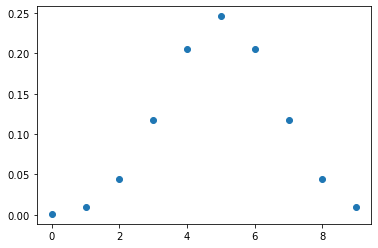

In [10]:
# For discrete distribution these rules change a bit , the pdf function is replaced by pmf:
X = np.arange(0,10)
plt.scatter( X , stats.binom.pmf( X ,  n = 10 , p = 0.5 ) ) # binomial distribution with 10 draws and a 0.5 probability of success
plt.show()

Most distributions have a certain number of **parameters** which may control their overall **shape, location or scale**.

For Instance the normal law has two parameters : its mean ($\mu$) and its standard deviation ($\sigma$), which respectively control its location and scale. In `scipy`, these are expressed in terms of `loc` (location) and `scale`.

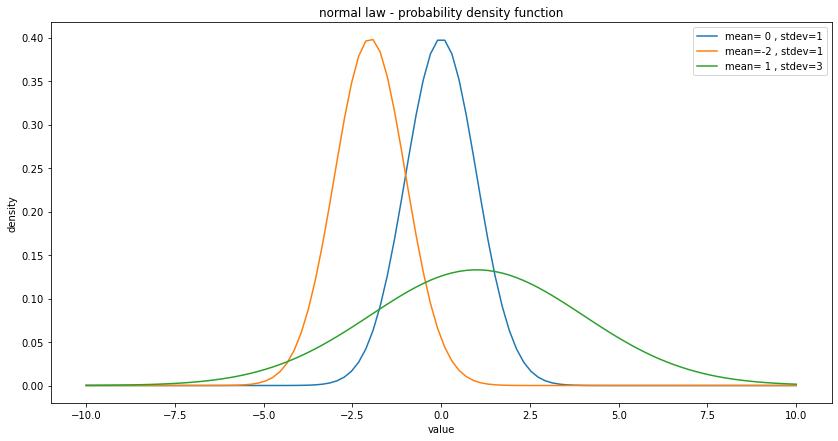

In [11]:
x = np.linspace(-10,10, 100) # 100 equally separated points between -5 and 5
fig, ax = plt.subplots(figsize=(14, 7))

a= sns.lineplot(x=x, y=stats.norm.pdf(x , loc = 0 , scale = 1) , ax = ax , label='mean= 0 , stdev=1')
sns.lineplot(x=x, y=stats.norm.pdf(x , loc = -2 , scale = 1 ) , ax = ax , label='mean=-2 , stdev=1')
sns.lineplot(x=x, y=stats.norm.pdf(x , loc = 1 , scale = 3 ) , ax = ax , label='mean= 1 , stdev=3')

a.set(xlabel='value', ylabel='density')
a.set_title('normal law - probability density function')
ax.legend()




[back to toc](#toc)

<br>

## 1.2 t-test <a id='stats.2'></a>

The **t-test** is used to determine if the means of two samples (drawn from 2 sub-populations for instance) are significantly different.

It is a widely used test, with important but not overly complex assumptions:
 * independence of data points
 * the means of each sample should follow normal distributions
 * *the two sample share the came variance* <- different flavors of the test depending on that one.

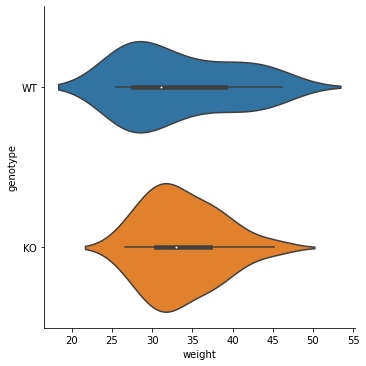

In [12]:
mice_data = pd.read_csv( 'data/mice_data.csv' ) # data about the weight of mices of different genotypes and subjected to different diets
sns.catplot(x='weight' , y='genotype' , data=mice_data , kind='violin')

In [13]:
WTdata = mice_data['weight'][ mice_data['genotype'] == 'WT' ]
KOdata = mice_data['weight'][ mice_data['genotype'] == 'KO' ]

tstat , pval = stats.ttest_ind( KOdata , WTdata , equal_var=False)#use equal_var=True if you have tested for variance equality
print('test statistic : ',tstat , sep='\t')
print('p-value : ',pval , sep='\t')

test statistic : 	0.18836850422505863
p-value : 	0.8514498629523397


### **micro exercise :** 
there is another column in the data-set : `diet`, which can take the values `"HFD"` and `"CHOW"`. Perform a t-test exactly as before, but splitting mice by their `diet` rather than their `genotype`.

In [14]:
mice_data.head()

,diet,genotype,weight
0,HFD,WT,31.2
1,HFD,WT,32.1
2,HFD,WT,30.3
3,HFD,WT,45.0
4,HFD,WT,39.2


[back to toc](#toc)

<br>

## 1.3 statistical power calculations <a id='stats.3'></a>


For wome widely used tests, functions let you automatically compute statistical power for a given effect size or sample size 

In [15]:
from statsmodels.stats.power import TTestIndPower


mean_difference=1
standard_dev=1
sample_size=10

effect_size = mean_difference/standard_dev

P = TTestIndPower()
print( 'power:' , P.power(effect_size=effect_size , nobs1=sample_size , ratio=1 , alpha=0.05) )

power: 0.5620066386966457


**Calculating statistical power can help inform our experimental design**. 

For example, how many observation per sample do we need if we want to detect a difference in mean of 1 with significance level (type I error) 0.01 and statistical power 0.80:

minimum sample size: 25.066708773444212


/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


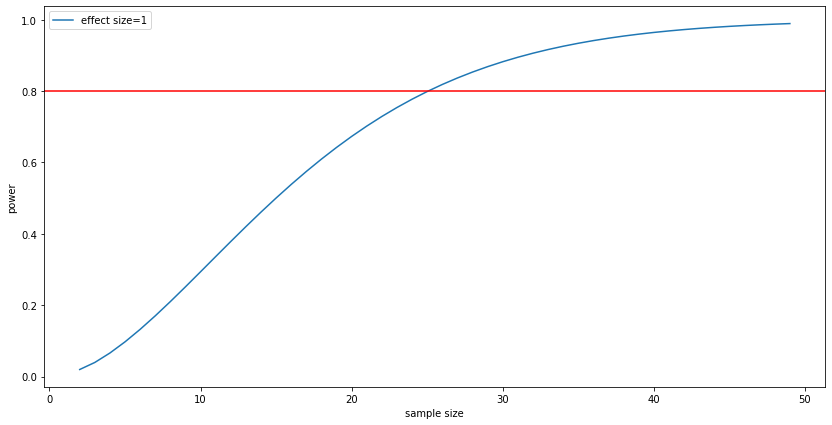

In [16]:
effect_size=1
sig_threshold = 0.01
P = TTestIndPower()

powers = []
for sample_size in range(2,50):
    powers.append( P.power(effect_size=effect_size , nobs1=sample_size , ratio=1 , alpha=sig_threshold) )

fig,ax=plt.subplots(figsize=(14,7))
sns.lineplot(range(2,50) , powers , label = 'effect size='+str(effect_size) , ax=ax)
ax.axhline(0.8, color='r', linestyle='-')
ax.set(xlabel='sample size', ylabel='power')


## or, directly:
print( 'minimum sample size:', P.solve_power(effect_size=effect_size , nobs1=None ,  ratio=1 , alpha=sig_threshold , power = 0.8))

[back to toc](#toc)

<br>

## 1.4 Multiple hypothesis testing <a id='stats.4'></a>


Recall the definition of the p-value: the probability of obtaining a test statistic at least as extreme as the one observed, **if the null hypothesis is true**

Thus, *even* if the p-value is, let's say, 0.04, there is still a 4% chance of obtaining such an extreme result by chance.

This is often acceptable if we only perform one test, if we perform many tests we have seen (with the simulations), that even when there is no real effect some tests will turn out significant by chance.

> This is the definition of the $\alpha$ risk fo type I error is.

Of course, this has important implication for science and the relevance of our results.

![image.png](img/xkcd882.png)

> source : [xkcd](http://xkcd.com) (note: there are many relevant xkcd strips for everything related to stats/programming courses)

/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'number of tests'),
 Text(0, 0.5, 'probability of at least 1 test significant by chance')]

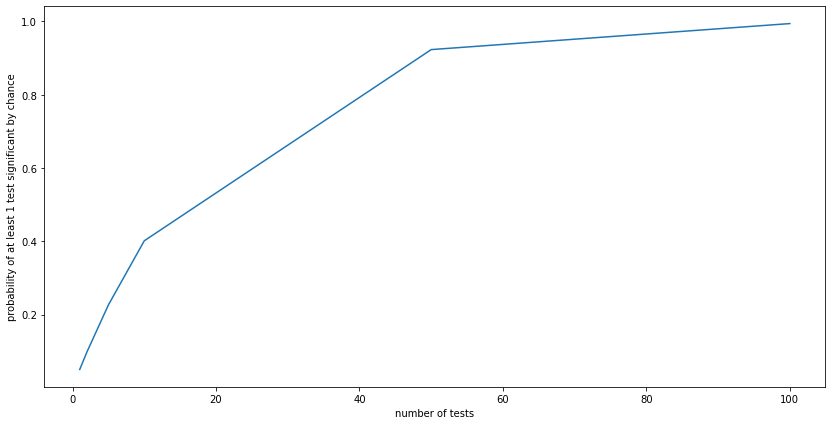

In [17]:
P = np.array([1, 2, 5, 10, 50, 100])
fig,ax=plt.subplots(figsize=(14,7))
sns.lineplot( P , 1- 0.95**P ,ax=ax)
ax.set(xlabel='number of tests', ylabel='probability of at least 1 test significant by chance')



We need to change perspective.
Instead of trying to limit the false positive probability for *each* test, we focus on:
* the probability of obtaining **any** false positives (family-wise error rate, **FWER**)
* the proportion of false positives among all findings (false discovery rate, **FDR**)

> Controlling the FWER is often too stringent - limit type I errors, but get lots of type II errors. 

### The Bonferroni method for controlling the FWER

- Assume we are performing $N$ tests
- To control the FWER at (e.g.) 0.05, only call variables with p-values below $0.05/N$ significant



### The Benjamini-Hochberg method for controlling the FDR

- Assume we are performing $N$ tests
- Intuition: for each p-value threshold $\alpha$, we can estimate the number of false discoveries by $\alpha N$
- Compare this to the actual number of discoveries at the threshold - $N_\alpha$
- Choose a p-value threshold $\alpha$ such that $\alpha N/N_\alpha$ is less than a desired threshold (e.g. 0.05) - this threshold would give an expected FDR of 0.05
- Note that the FDR is truly a property of a *set* - in a set of genes with FDR = 0.05, we can expect around 5% to be false discoveries. However, we don't know *which* ones! It could be the most significant!
- Often, we want a gene-wise measure of significance (like the p-value)
- The q-value, or adjusted p-value, of a variable is the *smallest* FDR we have to accept in order to call that variable significant.
- For example, if the adjusted p-value is 0.2, we have to accept that if we want to call this variable (and consequently, all variables with lower p-values) significant, there will be approximately 20% false discoveries among them.

In python :

```python
from statsmodels.stats.multitest import multipletests

# Bonferroni
rejected,fwers,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='bonferroni')

# BH procedure
rejected,fdrs,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Note: many other methods are available -> help(multipletests)
```

* rejected : true for hypothesis that can be rejected for the given alpha
* fwers|fdrs : p-values corrected for multiple tests
* alphacSidak : corrected alpha for Sidak method
* alphacBonf : corrected alpha for Bonferroni method
        

In [18]:
# imagine we perform 10 000 tests of 10 000 random data-sets
pvals = []

N=10000
mean_difference=0 # no differences -> any detected difference is due to chance
sample_size = 100
std=1

for i in range(N):
    t , pval_ttest = stats.ttest_ind( np.random.randn( sample_size ) * std , 
                                     np.random.randn( sample_size ) * std + mean_difference ,equal_var=True)
    
    pvals.append(pval_ttest)
pvals = np.array(pvals)
# stats models proposes a function implementing numerous p-value correction methods
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

from statsmodels.stats.multitest import multipletests

rejected,fwers,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='bonferroni')
rejected,fdrs,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')

Fraction of (spuriously) significant tests:
p-value: 0.0496
FWER   : 0.0
FDR    : 0.0


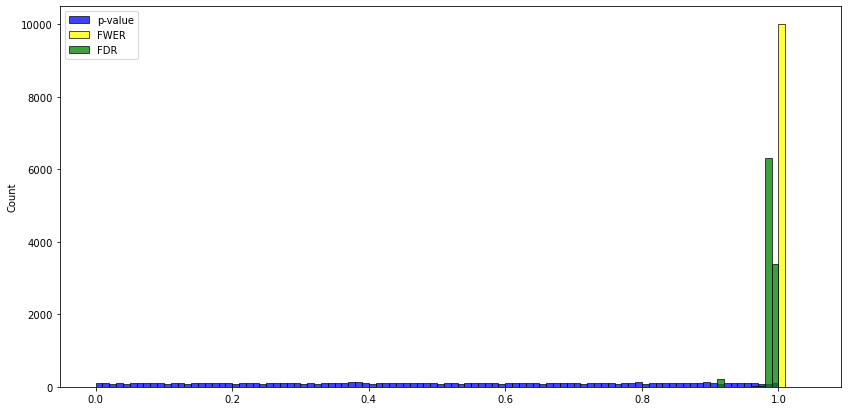

In [19]:
fig,ax=plt.subplots(figsize=(14,7))
sns.histplot( pvals ,bins = np.arange(0,1.05,0.01) ,  ax = ax , label = 'p-value' , color='blue')
sns.histplot( fwers ,bins = np.arange(0,1.05,0.01) ,   ax = ax , label = 'FWER' , color='yellow')
sns.histplot( fdrs  ,bins = np.arange(0,1.05,0.01) ,  ax = ax , label = 'FDR' , color='green')

print('Fraction of (spuriously) significant tests:')
print('p-value:' , sum(pvals<0.05)/N )
print('FWER   :' , sum(fwers<0.05)/N )
print('FDR    :' , sum(fdrs <0.05)/N )
plt.legend()

[back to toc](#toc)

<br>

## 1.5 Fisher's exact test and the Chi-square test <a id='stats.5'></a>

These two tests have for object the association between 2 categorical variables.

Their **null hypothesis** is the absence of association between the two variable.


**Fisher's exact test**, as its name entails, computes a p-value which is exact, even for very low smaple sizes. However it becomes computationnaly complex to compute as the data set size or number of categories gets high.

The **Chi-square test**, in contrast, uses an approximation of the exact p-value which is only valid when samples are big enough. However, it scales well to larger samples sizes and number of categories.


Both tests start from a **contingency table**.

We are going to use as example the historical [Lady tasting tea](https://en.wikipedia.org/wiki/Lady_tasting_tea).

|  | detected as milk before | detected as milk after | marginal sums |
|---|---|---|---|
| **milk before** | 3 | 1 | **4** |
| **milk after** | 1 | 3 | **4** |
| **marginal sums**  | **4** | **4** | **8** |

In our experiment, the lady was able to correctly identify 6 out of 8 cups.





In [20]:
## fisher exact test

table = [[3,1],[1,3]]

oddsratio , pvalue = stats.fisher_exact(table)
print("Fisher's exact test")
print('\todds ratio:',oddsratio)
print('\tp-value:',pvalue)

### chi square
chi2,pval , df, expected = stats.chi2_contingency(table , correction=False)
print("Chi-square test")
print('\tchi2:', chi2)
print('\tp-value:', pval)

Fisher's exact test
	odds ratio: 9.0
	p-value: 0.48571428571428527
Chi-square test
	chi2: 2.0
	p-value: 0.15729920705028105


You can see here that the returned p-value is quite different from the one given by Fisher's exact test.

> note that here we use `correction=False` as by default scipy implementation uses [Yates's correction](https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity), which is useful when the effectives are low. Try the same lines with the correction to see the difference.



Let's imagine now that we have a many cups and very patient lady so that the contigency table looks like this:

|  | detected as milk before | detected as milk after | marginal sums |
|---|---|---|---|
| **milk before** | 25 | 15 | **40** |
| **milk after** | 18 | 22 | **40** |
| **marginal sums**  | **40** | **40** | **80** |



In [21]:
table = [[25,15],[18,22]]

oddsratio , pvalue = stats.fisher_exact(table)
print("Fisher's exact test")
print('\todds ratio:',oddsratio)
print('\tp-value:',pvalue)

chi2,pval , df, expected = stats.chi2_contingency(table , correction=False)
print("Chi-square test")
print('\tchi2:', chi2)
print('\tp-value:', pval)

Fisher's exact test
	odds ratio: 2.037037037037037
	p-value: 0.17815079712391613
Chi-square test
	chi2: 2.4638592080452546
	p-value: 0.11649225257988546


You can see that the p-value of the Chi-square test is now much closer to that of Fisher's exact test.

# Excercise

Come back to the census data from 1880, in particular in the file `'census1880_fractions.csv'` file we have kept the data as fraction and created a few categories.

Test the association between majority religion (`'majority_religion'`) and majority language (`'majority_language'`).

> Tip: to create a contingency table :

> ```table = pd.crosstab( dfFractions['majority religion'] , dfFractions['majority language'] )```


**extra question if you have the time :** How could you make Fisher's test work here?

In [22]:
dfFractions = pd.read_csv('data/census1880_fractions.csv')

In [23]:
dfFractions.head()

,Unnamed: 0,town name,canton,canton name,Total,Swiss,Foreigner,Male,Female,0-14 y.o.,...,Reformed,Catholic,Other,German speakers,Franch speakers,Italian speakers,Romansche speakers,Non-national tongue speakers,majority religion,majority language
0,0,Aeugst,ZH,Zürich,646,0.970588,0.029412,0.493808,0.506192,0.335913,...,0.910217,0.066563,0.023220,0.998452,0.000000,0.001548,0.0,0.000000,Reformed,German speakers
1,1,Affoltern am Albis,ZH,Zürich,2201,0.948660,0.051340,0.479328,0.520672,0.323944,...,0.882326,0.098137,0.019537,0.996365,0.002272,0.001363,0.0,0.000000,Reformed,German speakers
2,2,Bonstetten,ZH,Zürich,771,0.977951,0.022049,0.468223,0.531777,0.345006,...,0.968872,0.025940,0.005188,1.000000,0.000000,0.000000,0.0,0.000000,Reformed,German speakers
3,3,Hausen,ZH,Zürich,1363,0.957447,0.042553,0.469552,0.530448,0.251651,...,0.928833,0.069699,0.001467,0.984593,0.008804,0.006603,0.0,0.000000,Reformed,German speakers
4,4,Hedingen,ZH,Zürich,907,0.955899,0.044101,0.493936,0.506064,0.281147,...,0.949283,0.048512,0.002205,0.984564,0.000000,0.009923,0.0,0.005513,Reformed,German speakers


[back to toc](#toc)

<br>

## 1.6 1-way anova <a id='stats.6'></a>

The ANOVA, or ANalyse Of VAriance, stands maybe among the most used (and abused) type of statistical tests to date.

The anova is used to analyze the differences among group means in a sample. 
In particular, we are going to concentrate here on the 1-way ANOVA, which evaluates the difference in means of a numerical variable across groups formed by another (single) variable.

In this sense, it is a generalization of the t-test which is limited to 2 groups only (in fact, the 1-way anova and t-test are quivalent when there are only 2 groups).

**Anova assumptions** :
* subpopulation distributions are normal
* samples have equal variances
* observations are independent from one another

**Test hypothesis** : 
given $m$ groups of mean $\bar{x}_{1...m}$, each containing $n_i$ observations (for a total of $n$)
 * **Null hypothesis** : $H_0 : \bar{x}_1 = \bar{x}_2 = ... = \bar{x}_m$
 * **Alternative hypothesis** : At least one of these means differ from the others
 
The anova relies on the idea that if the mean varies between the different group then the overall variance of all samples should be significantly greater than the variance within each group (hence the name).


/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/wandrille/Installed_software/anacon

<AxesSubplot:xlabel='subSpecies', ylabel='plantSize'>

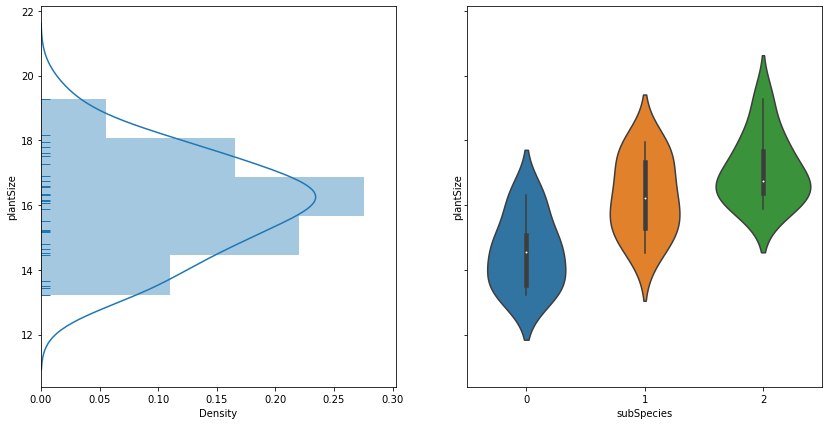

In [29]:
# imagine we measure the height of the same number of individuals individuals in 3 plant subspecies
sampleSize = 10
numberOfGroups = 3
dfPlant = pd.DataFrame({'subSpecies' : [0]*sampleSize + [1]*sampleSize + [2]*sampleSize ,
                        'plantSize' : np.concatenate( ( np.random.randn(sampleSize) + 15 , 
                                                       np.random.randn(sampleSize) + 16 , 
                                                       np.random.randn(sampleSize) + 17 )) } )
fig,axes = plt.subplots(1,2 , figsize=(14,7),  sharey=True )
sns.distplot(dfPlant['plantSize'] , rug=True, ax = axes[0] , vertical=True)
sns.violinplot(x='subSpecies', y='plantSize' , data=dfPlant, kind = 'violin' , ax = axes[1])

In [32]:
dfPlant

,subSpecies,plantSize
0,0,15.649303
1,0,15.165164
2,0,16.610405
3,0,15.168177
4,0,14.467741
5,0,14.927726
6,0,15.838598
7,0,14.049036
8,0,15.666626
9,0,13.654972


In [30]:
Fstat , pval = stats.f_oneway( dfPlant['plantSize'][dfPlant['subSpecies'] == 0],
                dfPlant['plantSize'][dfPlant['subSpecies'] == 1],
                dfPlant['plantSize'][dfPlant['subSpecies'] == 2] )
print('automated 1-way anova / F-test:')
print('F-stat :',Fstat)
print('p-value:',pval)


automated 1-way anova / F-test:
F-stat : 13.713197317080025
p-value: 7.762143563317372e-05


[back to toc](#toc)

<br>

# 2. Correlation and linear regression <a id='reg'></a>

## 2.1 Correlation <a id='reg.1'></a>

**Correlation** is a measure of the amount of relatedness between two measured variables. It comes in several flavours :
 * Pearson's linear correlation coefficient : for linear relationship only : `stats.pearsonr(x,y)`
 * Spearman's rank correlation coefficient : accepts non linear, but "monotonic only" : `stats.spearmanr(x,y)`
 * Kendall's Tau : relies on an order relation only and less influenced by the scale as the others : `stats.kendalltau(x,y)`



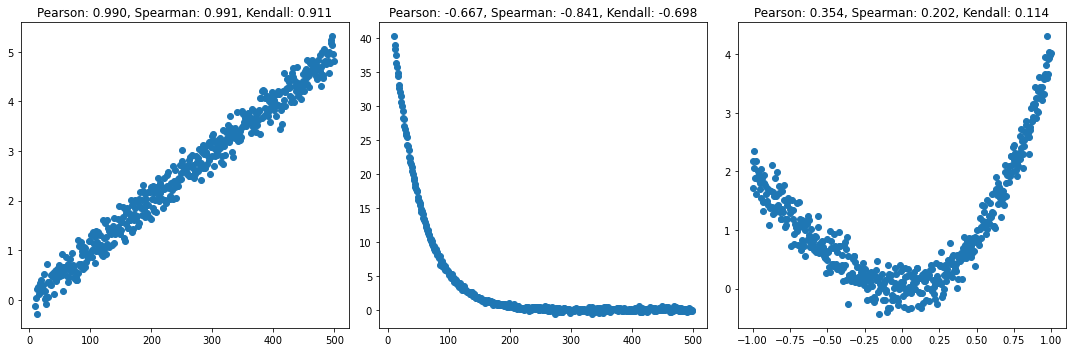

In [31]:
sigma=1./5

linear=[[u,(u)/100+sigma*np.random.randn()] for u in range(10,500)]
monotonic=[[u,50*(0.8**(u/10))+sigma*np.random.randn()] for u in range(10,500)]

non_monotonic=[[u,(u)**3+3*u**2+sigma*np.random.randn()] for u in np.arange(-1,1,1./250)]

together=[linear,monotonic,non_monotonic]
plt.subplots(133,figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    x=[u[0] for u in together[i]]
    y=[u[1] for u in together[i]]
    plt.scatter(x,y)
    plt.title('Pearson: {0:.3f}, Spearman: {1:.3f}, Kendall: {2:.3f}'.format(
                                    stats.pearsonr(x,y)[0],##just like that
                                    stats.spearmanr(x,y)[0],
                                    stats.kendalltau(x,y)[0]))
plt.tight_layout()    
plt.show()


[back to toc](#toc)

<br>

## 2.2 Regression <a id='reg.2'></a>

Performing regression (linear or otherwise) is possible with `scipy`, but it is not the best.

`statsmodels` offers much nicer options and statistical reports. Additionnally, this is a great opportunity to see together how to install a library. 

1. go to [https://www.statsmodels.org](https://www.statsmodels.org)
2. click on the install page 
3. find the instruction for installation with Anaconda 
4. type the command in either a terminal (mac,linux) or in the anaconda-prompt (windows)


In [33]:
import statsmodels
print('OK')

OK


In [34]:
df_diabetes = pd.read_table( "data/diabetes.csv" , sep=',' )
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


<AxesSubplot:xlabel='bmi', ylabel='disease progression'>

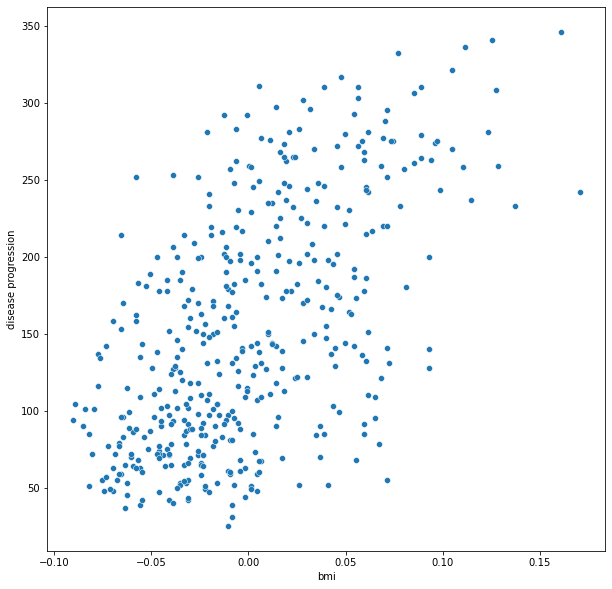

In [35]:
#pulling all the data together in the same dataFrame

x = df_diabetes['bmi'] # covariable bmi
y = df_diabetes['disease progression'] # response variable disease progression


fig, ax = plt.subplots( figsize = (10,10)) #setup graphical windows
sns.scatterplot(x=x,y=y) # plot x versus y


In [36]:
stats.pearsonr(df_diabetes['bmi'],
               df_diabetes['disease progression'] )

(0.5864501344746887, 3.4660064451654114e-42)

In [37]:
## We'll be using the statsmodel package, which computes a lot of cool metrics for you
import statsmodels
import statsmodels.api as sm

X = sm.add_constant(x)## adding a intercept to the model
model = sm.OLS(y, X)  ## defining an Ordinary Least Square variable
results = model.fit() ## fitting it

print( results.summary() )

                             OLS Regression Results                            
Dep. Variable:     disease progression   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.342
Method:                  Least Squares   F-statistic:                     230.7
Date:                 Tue, 25 May 2021   Prob (F-statistic):           3.47e-42
Time:                         11:38:40   Log-Likelihood:                -2454.0
No. Observations:                  442   AIC:                             4912.
Df Residuals:                      440   BIC:                             4920.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.974     51.16

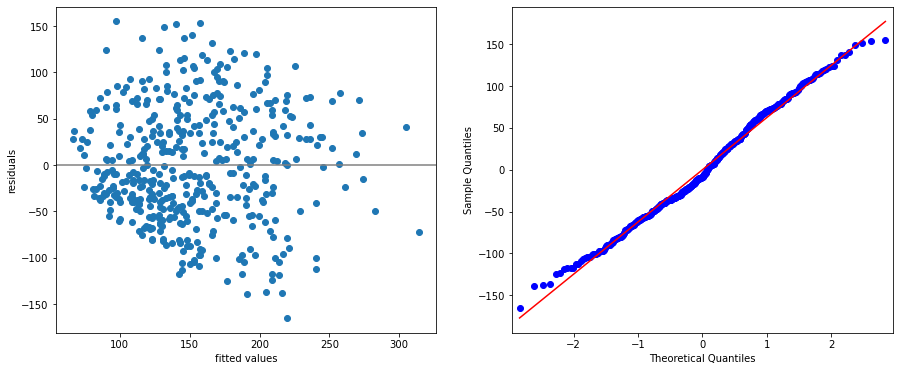

In [38]:
## diagnostic plots :
from statsmodels.graphics.gofplots import qqplot
fig,axes = plt.subplots(1,2,figsize = (15,6))

# plotting residuals (error of the model) vs. fitted values (prediction fo the model)
# helps determine homoskedascticity and sphericity of errors  :
# the points should show about the same spread all along the x axis, and be centered around 0.
axes[0].scatter( results.fittedvalues , results.resid )
axes[0].axhline(0.0 , color = 'grey')
axes[0].set_xlabel('fitted values')
axes[0].set_ylabel('residuals')

# the QQplot (quantile-quantile plot) is  great plot to assess normality of the model's residual
# basically points should stay close to the diagonal line if they follow something close to a normal distribution.
qqplot(results.resid , ax = axes[1] , line='s') 

plt.show()



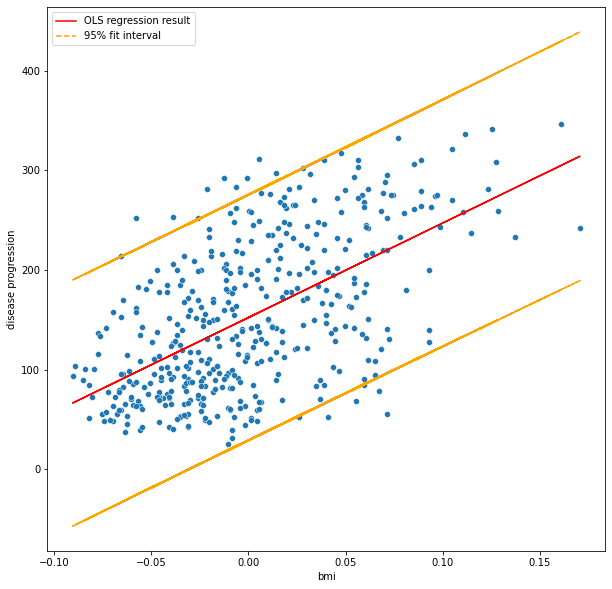

In [39]:
###Plotting the fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# we obtain the predicted values for our model, as well as their 95% intervals
prstd, iv_l, iv_u = wls_prediction_std(results) 

fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(x, y, 'o', label="data")
sns.scatterplot(x=x,y=y) # plot x versus y
ax.plot(x, results.fittedvalues, 'r', label="OLS regression result")
ax.plot(x, iv_u, color='orange',linestyle='--' , label='95% fit interval')
ax.plot(x, iv_l, color='orange',linestyle='--')
ax.legend(loc='best',fontsize=10)
#plt.yscale('log')

### Going further : using R-style formula in statsmodels

If you have been doing some regression in R, you would have come across *formula*, where instead of different dataframes for dependent variable covariables, on gives a single `DataFrame` along with a formular of the type `y ~ x`.

These offer a fairly simple and elegant way of specifying your model, with an efficient hamdling of intercepts, as well as interaction effects.

Going into details on these formula is beyond the scope of this course, but we encourage you to go though this very well made tutorial: https://www.statsmodels.org/devel/example_formulas.html